In [1]:
import pandas as pd
import regex as re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Loading in the Data

In [2]:
raw_df = pd.read_csv('Arsenic_Cancer_Final_2020Sept2.csv')
raw_df.head()

,FIPS,State,County,Population_Served,Bladder_Count,Colorectal_Count,Kidney_Count,Total_CWS_County,unweighted,weighted,...,Percent_Ever_Had_Endoscopy,Percent_Ever_Smoked,EQI_AIR,EQI_WATER,EQI_LAND,EQI_SD,EQI_BUILT,EQI_OVERALL,unweighted_cat,weighted_cat
0,6001,California,Alameda,328325,238,506,178,14,13.817619,14.701407,...,51.2,31.4,1.248786,1.272580,1.107635,-1.271590,-1.197254,1.905717,3,4
1,6003,California,Alpine,50,0,0,0,5,11.000000,27.111489,...,52.7,53.7,-1.253785,0.237081,0.746264,0.465065,-1.628784,0.229474,2,4
2,6005,California,Amador,5700,14,20,10,25,12.004667,11.216885,...,58.3,53.4,-0.507835,1.228148,1.141606,-0.707772,-0.597835,0.859964,2,3
3,6007,California,Butte,100086,67,105,36,53,19.324346,11.411614,...,52.2,44.5,0.138752,0.861382,1.038305,0.375840,-0.919210,0.689724,3,3
4,6009,California,Calaveras,1400,17,23,12,19,13.356833,13.014471,...,51.8,46.4,-0.678254,0.940576,0.626451,-0.491926,-0.031106,0.314156,3,4


In [3]:
# Checking raw dataframe shape
raw_df.shape

(943, 23)

# EDA

In [4]:
# Cheacking for any null fields
raw_df.isna().sum().any()

False

In [5]:
# Dropping columns that wont be used in the model
drop_list = ['FIPS', 'County', 'weighted', 'unweighted_cat', 'weighted_cat']
cut_df = raw_df.drop(drop_list, axis=1)

# Renaming our target variable
cut_df.rename(columns={'unweighted':'Arsenic Concentration'}, inplace=True)

cut_df.shape

(943, 18)

In [6]:
# Checking data types
cut_df.dtypes

State                                              object
Population_Served                                   int64
Bladder_Count                                      object
Colorectal_Count                                   object
Kidney_Count                                        int64
Total_CWS_County                                    int64
Arsenic Concentration                             float64
Percent_Male                                      float64
Percent_Black                                     float64
Percent_Same_County_Residence_At_Least_5_Years    float64
Percent_Ever_Had_Endoscopy                        float64
Percent_Ever_Smoked                               float64
EQI_AIR                                           float64
EQI_WATER                                         float64
EQI_LAND                                          float64
EQI_SD                                            float64
EQI_BUILT                                         float64
EQI_OVERALL   

In [7]:
# Changing the data types for Bladder and Colorectal counts to int

# Stripping the instances of ".00" in the Bladder and Colorectal counts columns
cut_df['Bladder_Count'] = cut_df['Bladder_Count'].apply(lambda x: re.sub(r'\.\d+', '', x))
cut_df['Colorectal_Count'] = cut_df['Colorectal_Count'].apply(lambda x: re.sub(r'\.\d+', '', x))

# Stripping the comma 
cut_df['Bladder_Count'] = cut_df['Bladder_Count'].apply(lambda x: re.sub(r',', '', x))
cut_df['Colorectal_Count'] = cut_df['Colorectal_Count'].apply(lambda x: re.sub(r',', '', x))

# Converting to int64
cut_df[['Bladder_Count', 'Colorectal_Count']] = cut_df[['Bladder_Count', 'Colorectal_Count']].astype('int64')

In [8]:
# Checking the unique state names and occurences
cut_df['State'].value_counts()

Kentucky          120
Missouri          115
Iowa               99
Wisconsin          72
Florida            67
Pennsylvania       67
New York           62
California         58
West Virginia      55
South Carolina     46
Washington         39
Oregon             36
Maryland           24
New Jersey         21
Maine              16
Massachusetts      14
Vermont            14
New Hampshire      10
Connecticut         8
Name: State, dtype: int64

In [9]:
cut_df.describe()

,Population_Served,Bladder_Count,Colorectal_Count,Kidney_Count,Total_CWS_County,Arsenic Concentration,Percent_Male,Percent_Black,Percent_Same_County_Residence_At_Least_5_Years,Percent_Ever_Had_Endoscopy,Percent_Ever_Smoked,EQI_AIR,EQI_WATER,EQI_LAND,EQI_SD,EQI_BUILT,EQI_OVERALL
count,9.430000e+02,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000
mean,2.503172e+04,39.513256,66.852598,25.582185,19.427359,21.510506,49.435737,5.709968,79.642842,58.030965,48.593955,0.374096,0.075973,0.191618,-0.170216,-0.233519,0.348309
std,1.791941e+05,85.375377,164.188348,60.148519,26.982592,71.010701,1.707933,10.643923,6.353416,6.323328,6.593366,0.767628,1.079377,0.821959,0.969990,0.847427,0.889027
min,1.300000e+01,0.000000,0.000000,0.000000,1.000000,2.748254,44.400000,0.000000,51.700000,30.000000,25.700000,-2.012817,-1.641266,-5.044657,-3.537189,-2.614966,-2.929698
25%,9.100000e+01,5.000000,9.000000,3.000000,4.000000,7.062917,48.500000,0.300000,76.100000,54.400000,44.800000,-0.179368,-1.433685,-0.110076,-0.783342,-0.841909,-0.227296
50%,4.750000e+02,12.000000,20.000000,8.000000,10.000000,12.893487,49.200000,1.400000,80.500000,58.300000,49.400000,0.333733,0.656822,0.362001,-0.189326,-0.385892,0.379364
75%,3.000500e+03,34.500000,51.500000,22.000000,24.000000,22.831111,49.900000,6.000000,84.000000,62.000000,53.000000,0.922689,0.958767,0.755333,0.430940,0.199954,0.958703
max,2.504700e+06,1454.000000,3317.000000,1162.000000,246.000000,1487.869549,64.700000,71.000000,94.200000,79.000000,67.500000,2.789840,1.478177,2.094526,3.081295,3.992723,2.700445


In [10]:
# There is a large range regarding the concentrations, dropping the top end values as they are not normal.
cut_df = cut_df[cut_df['Arsenic Concentration'] < 43]

# There is a large range regarding the Bladder, Colorectal, and Kidney values. Dropping the top end Colorectal value as it is
# substancially larger.
cut_df = cut_df[cut_df['Colorectal_Count'] < 1500]

cut_df.shape

(896, 18)

# Visualizations

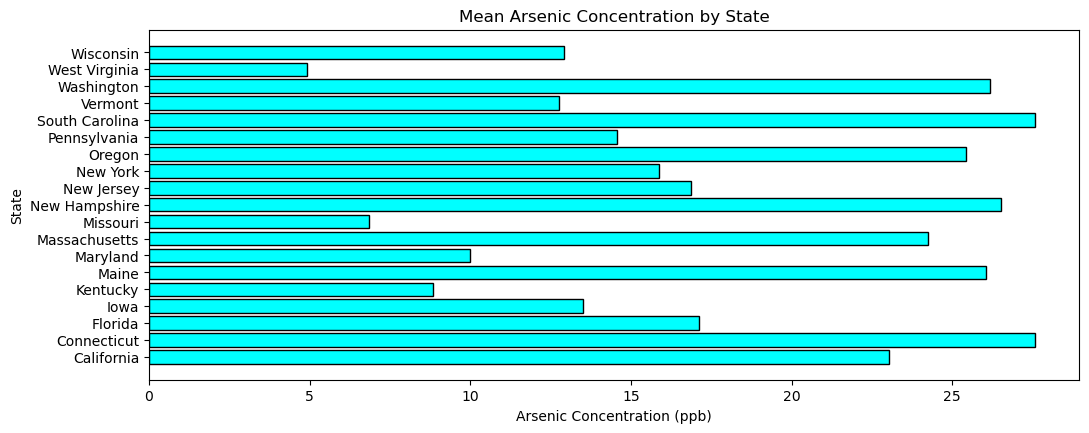

In [11]:
# Grouping data together by state
grouped_state = cut_df.groupby(['State']).mean(numeric_only=True)

fig = plt.figure(figsize=(12,10))

# Bar chart containing all state and concentation data
ax1 = plt.subplot(211)
ax1.barh(grouped_state.index, grouped_state['Arsenic Concentration'], color='aqua', edgecolor='black')
ax1.set_ylabel('State')
ax1.set_xlabel('Arsenic Concentration (ppb)')
ax1.set_title('Mean Arsenic Concentration by State')
plt.show()

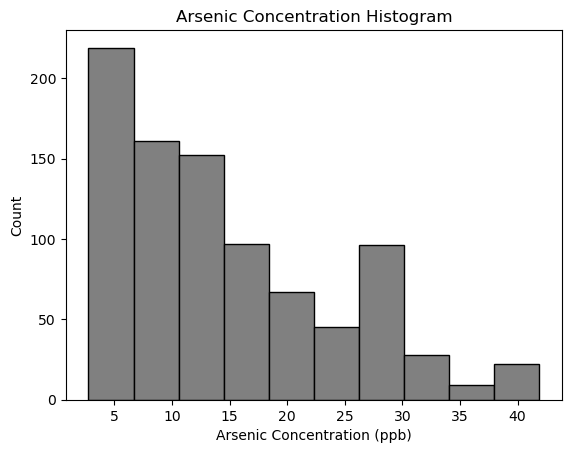

In [12]:
plt.hist(cut_df['Arsenic Concentration'], color='grey', edgecolor='black')
plt.title('Arsenic Concentration Histogram')
plt.xlabel('Arsenic Concentration (ppb)')
plt.ylabel('Count')
plt.show()

In [13]:
# Creating groups of similar columns
population_diseases = ['Bladder_Count', 'Colorectal_Count', 'Kidney_Count']
enviro_indexes = ['EQI_AIR', 'EQI_WATER', 'EQI_LAND', 'EQI_SD', 'EQI_BUILT']

def scatter_plots(col_list, palatte):
    # setting the column and index for our subplot
    col_n = 3
    ind = 1
    
    # Condition to apply the correct number of different colors
    clrs = []
    if palatte > 3:
        clrs = ['orange', 'green', 'cyan', 'red', 'grey']
    elif palatte <= 3:
        clrs = ['blue', 'lime', 'olive']
    
    # Determining the number of rows
    if len(col_list) > 3:
        row_n = 2
    else:
        row_n = 1
    
    fig = plt.figure(figsize=(13,7))
    for col in col_list:
        ax = plt.subplot(row_n,col_n,ind)
        ax.scatter(cut_df['Arsenic Concentration'], cut_df[col], color=clrs[0])
        ax.set_title(f'Arsenic Concetration vs {col}')
        ax.set_xlabel('Arsenic Concentration (ppb)')
        ax.set_ylabel(f'{col}')
        plt.tight_layout()

        ind += 1
        clrs.pop(0) # Drops the first color and the next will be applied

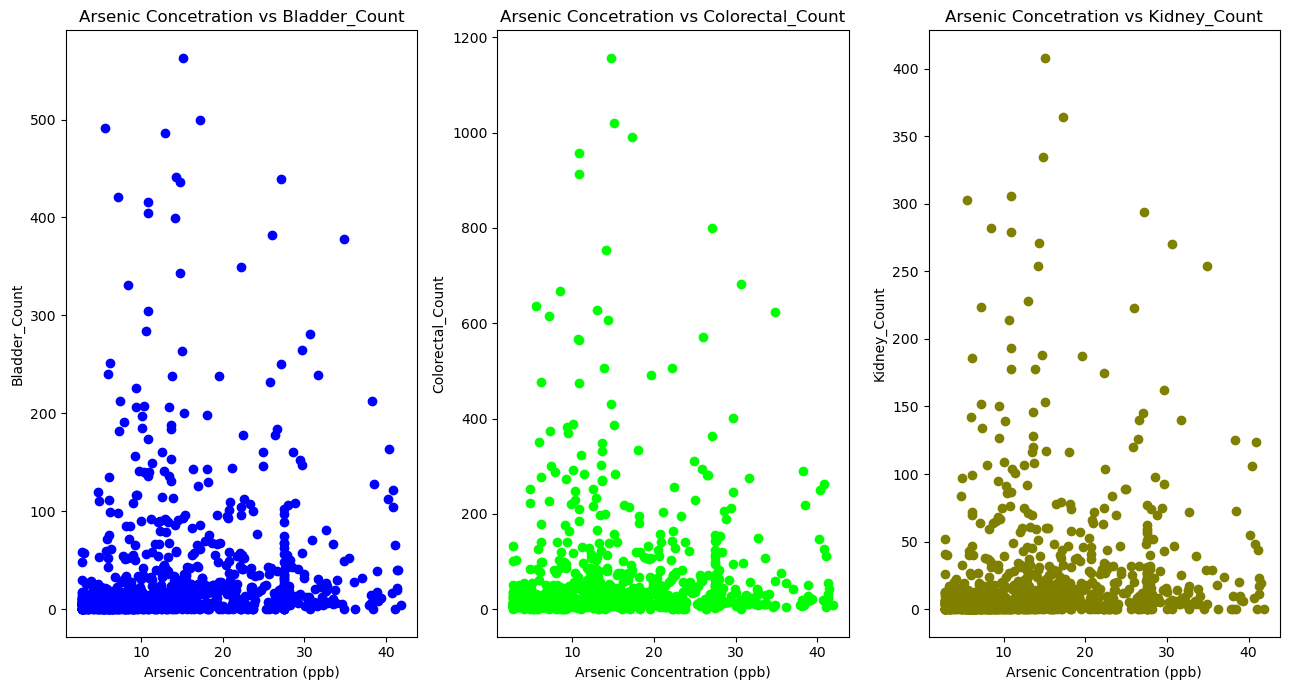

In [14]:
scatter_plots(population_diseases, len(population_diseases))

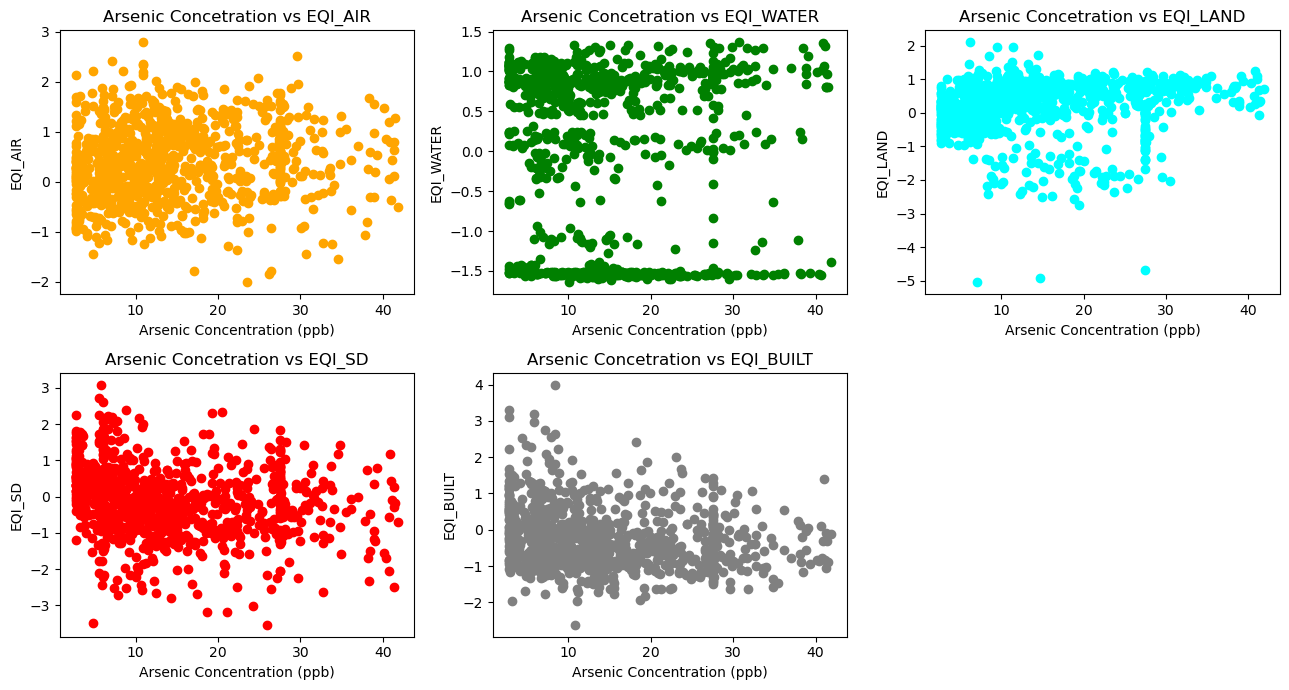

In [15]:
scatter_plots(enviro_indexes, len(enviro_indexes))

In [16]:
# Creating dummy variables
dummy_df = pd.get_dummies(cut_df, columns=['State'], drop_first=True)

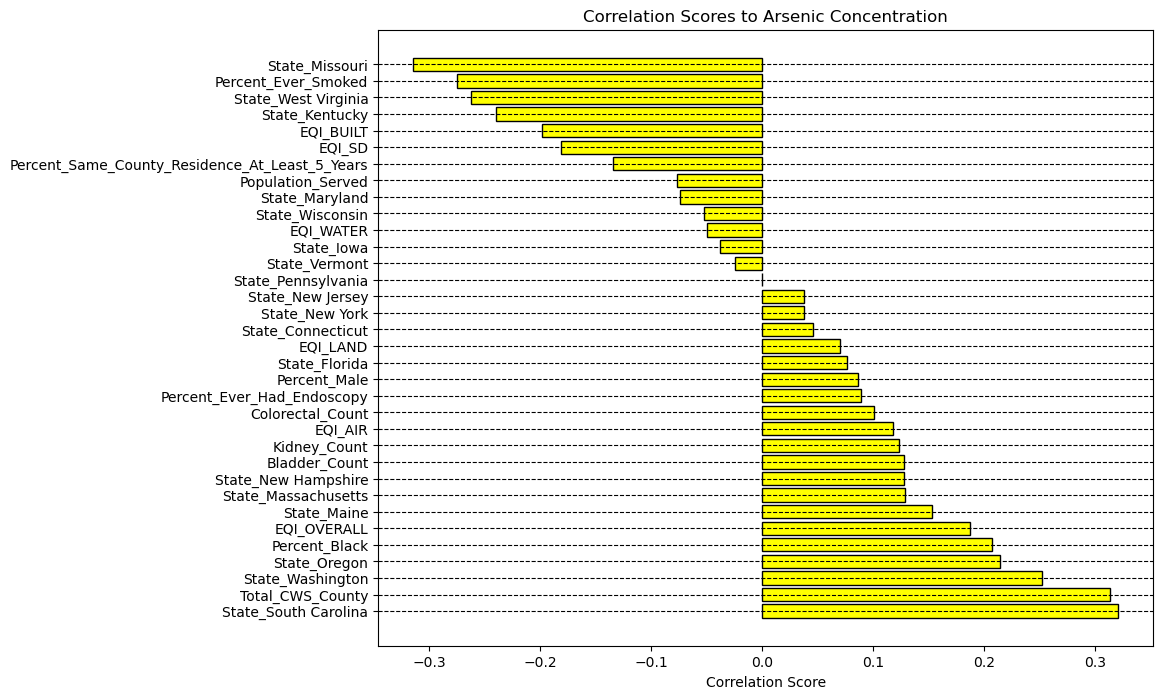

In [17]:
# Getting the correlation scores compared to our target variable (Concentration)
corrs = dummy_df.corrwith(dummy_df['Arsenic Concentration']).sort_values(ascending=False).drop('Arsenic Concentration')


plt.figure(figsize=(10,8))
plt.barh(corrs.index, corrs, color='yellow', edgecolor='black')
plt.grid(axis='y', color='black', linestyle='dashed')
plt.xlabel('Correlation Score')
plt.title('Correlation Scores to Arsenic Concentration')
plt.show()

# Model Preparation

In [18]:
# Creating a target and feature dataframe
target = dummy_df.loc[:, 'Arsenic Concentration']
raw_features = dummy_df.drop('Arsenic Concentration', axis=1)

In [19]:
# Scaling the features
sclr = StandardScaler()
features = sclr.fit_transform(raw_features)

In [20]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=50)
print(f'X_train:{X_train.shape}, X_test:{X_test.shape}\ny_train: {y_train.shape[0]}, y_test: {y_test.shape[0]}')

X_train:(716, 34), X_test:(180, 34)
y_train: 716, y_test: 180


# Metric Calculator

In [21]:
# Creating a dataframe to store metric results
metric_df = pd.DataFrame(columns=['Model', 'RMSE', 'R2 Percentage'])

def get_metrics(pred, ytest, model):
    rmse = round(mean_squared_error(pred, ytest, squared=False), 2)
    r2 = round(r2_score(pred, ytest), 2)*100
    metric_df.loc[len(metric_df.index)] = [model, rmse, int(r2)]

# Models

### Linear Regression

In [22]:
# Creating a Linear Regression instance
lr = LinearRegression()

# Fitting the training data
lr.fit(X_train, y_train)

# Making predictions
y_pred = lr.predict(X_test)
get_metrics(y_pred, y_test, 'Linear Regression')

### Bayesian Ridge

In [23]:
# Creating a Bayesian Ridge Regression
brm = BayesianRidge().fit(X_train, y_train)

# Making predictions
ybr_pred = brm.predict(X_test)

get_metrics(ybr_pred, y_test, 'Bayesian Ridge Regression')

### Decision Tree

In [24]:
# Creating a Decision Tree Regressor
dtr = DecisionTreeRegressor(random_state=20).fit(X_train, y_train)

# Making predictions
ydt_pred = dtr.predict(X_test)

get_metrics(ydt_pred, y_test, 'Decision Tree Regressor')

# Results

In [25]:
metric_df

,Model,RMSE,R2 Percentage
0,Linear Regression,6.94,18
1,Bayesian Ridge Regression,6.97,10
2,Decision Tree Regressor,10.06,16
